<a href="https://colab.research.google.com/github/KunalGaurav90/Blood_group_identification/blob/main/blood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install optuna
import optuna

# 1. Define the function you want to minimize (or maximize)
def objective(trial):
    # Suggest a value for 'x' between -10 and 10
    x = trial.suggest_float("x", -10, 10)
    # Return the result of the function
    return (x - 2) ** 2

# 2. Create and run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print(f"Best parameter: {study.best_params}")
print(f"Best value: {study.best_value}")

[I 2026-02-17 11:32:21,398] A new study created in memory with name: no-name-540da656-d77f-4e18-99c2-a9475a76e243
[I 2026-02-17 11:32:21,402] Trial 0 finished with value: 0.9195834300515386 and parameters: {'x': 1.041050872021076}. Best is trial 0 with value: 0.9195834300515386.
[I 2026-02-17 11:32:21,403] Trial 1 finished with value: 8.273488244382508 and parameters: {'x': 4.876367195679736}. Best is trial 0 with value: 0.9195834300515386.
[I 2026-02-17 11:32:21,405] Trial 2 finished with value: 135.32057685319745 and parameters: {'x': -9.632737289786848}. Best is trial 0 with value: 0.9195834300515386.
[I 2026-02-17 11:32:21,406] Trial 3 finished with value: 6.597494187889557 and parameters: {'x': 4.568558776413255}. Best is trial 0 with value: 0.9195834300515386.
[I 2026-02-17 11:32:21,407] Trial 4 finished with value: 77.51515378445052 and parameters: {'x': -6.804269065882216}. Best is trial 0 with value: 0.9195834300515386.
[I 2026-02-17 11:32:21,410] Trial 5 finished with value: 

Best parameter: {'x': 1.985673587606237}
Best value: 0.00020524609207616545


In [3]:
# Configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
import kaggle
kaggle.api.authenticate()

In [5]:
kaggle.api.dataset_download_files('rajumavinmar/finger-print-based-blood-group-dataset', path='.', unzip=True)
kaggle.api.dataset_metadata('rajumavinmar/finger-print-based-blood-group-dataset', path='.')

Dataset URL: https://www.kaggle.com/datasets/rajumavinmar/finger-print-based-blood-group-dataset


'./dataset-metadata.json'

In [6]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Define the path to the dataset directory
dataset_path = '/content/dataset_blood_group' # Adjust this path if your dataset is in a different location

# Get the list of blood group folders
blood_groups = os.listdir(dataset_path)
blood_groups.sort()

# Initialize lists to store images and labels
images = []
labels = []

# Load and preprocess images
image_size = (128, 128) # Define image size (can be adjusted)

for blood_group in blood_groups:
    folder_path = os.path.join(dataset_path, blood_group)
    if os.path.isdir(folder_path):
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            try:
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Load as grayscale
                if img is not None:
                    img = cv2.resize(img, image_size) # Resize image
                    img = img / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img)
                    labels.append(blood_group)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Display the shapes of the arrays
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (6000, 128, 128)
Labels shape: (6000,)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels to numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert labels to one-hot encoding
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42, stratify=labels_categorical)

# Split testing set into validation and testing sets
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Validation data shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)
print("Validation labels shape:", y_val.shape)

Training data shape: (4800, 128, 128)
Testing data shape: (600, 128, 128)
Validation data shape: (600, 128, 128)
Training labels shape: (4800, 8)
Testing labels shape: (600, 8)
Validation labels shape: (600, 8)


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG16
from tensorflow.keras.optimizers import Adam

# Get the number of classes from the shape of the categorical labels
num_classes = y_train.shape[1]

# Simple CNN
def build_simple_cnn(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

# ResNet50
def build_resnet50(input_shape, num_classes):
    # Use pre-trained ResNet50, excluding the top dense layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3)) # ResNet requires 3 channels
    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# InceptionV3
def build_inceptionv3(input_shape, num_classes):
    # Use pre-trained InceptionV3, excluding the top dense layers
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3)) # Inception requires 3 channels
    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# VGG16
def build_vgg16(input_shape, num_classes):
    # Use pre-trained VGG16, excluding the top dense layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3)) # VGG requires 3 channels
    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Build and compile each model
input_shape_cnn = (image_size[0], image_size[1], 1) # Simple CNN takes grayscale
simple_cnn_model = build_simple_cnn(input_shape_cnn, num_classes)
resnet_model = build_resnet50((image_size[0], image_size[1], 3), num_classes) # ResNet takes 3 channels
inception_model = build_inceptionv3((image_size[0], image_size[1], 3), num_classes) # Inception takes 3 channels
vgg_model = build_vgg16((image_size[0], image_size[1], 3), num_classes) # VGG takes 3 channels


# Compile models
simple_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
inception_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summaries
print("Simple CNN Summary:")
simple_cnn_model.summary()

print("\nResNet50 Summary:")
resnet_model.summary()

print("\nInceptionV3 Summary:")
inception_model.summary()

print("\nVGG16 Summary:")
vgg_model.summary()

Simple CNN Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,096 (12.61 MB)

 Trainable params: 3,305,096 (12.61 MB)

 Non-trainable params: 0 (0.00 B)


ResNet50 Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 27,783,176 (105.98 MB)

 Trainable params: 27,730,056 (105.78 MB)

 Non-trainable params: 53,120 (207.50 KB)


InceptionV3 Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 63, 63,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 63,    │         96 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 61, 61,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 61, 61,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        192 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 30, 30,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 30, 30,    │      5,120 │ max_pooling2d_3[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        240 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        576 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 22,852,520 (87.18 MB)

 Trainable params: 22,818,088 (87.04 MB)

 Non-trainable params: 34,432 (134.50 KB)


VGG16 Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,424 (60.14 MB)

 Trainable params: 15,764,424 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
print("Training Simple CNN...")
history_simple_cnn = simple_cnn_model.fit(X_train, y_train,
                                          epochs=10,
                                          batch_size=32,
                                          validation_data=(X_val, y_val))

print("\nTraining ResNet50...")
# ResNet requires 3 channels, convert grayscale to 3 channels by repeating the channel
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
X_val_rgb = np.repeat(X_val[..., np.newaxis], 3, axis=-1)

history_resnet = resnet_model.fit(X_train_rgb, y_train,
                                  epochs=10,
                                  batch_size=32,
                                  validation_data=(X_val_rgb, y_val))

print("\nTraining InceptionV3...")
# Inception requires 3 channels, convert grayscale to 3 channels by repeating the channel
history_inception = inception_model.fit(X_train_rgb, y_train,
                                        epochs=10,
                                        batch_size=32,
                                        validation_data=(X_val_rgb, y_val))


print("\nTraining VGG16...")
# VGG requires 3 channels, convert grayscale to 3 channels by repeating the channel
history_vgg = vgg_model.fit(X_train_rgb, y_train,
                            epochs=10,
                            batch_size=32,
                            validation_data=(X_val_rgb, y_val))

Training Simple CNN...
Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.4232 - loss: 1.4840 - val_accuracy: 0.7767 - val_loss: 0.5925
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7530 - loss: 0.6471 - val_accuracy: 0.8533 - val_loss: 0.4222
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8209 - loss: 0.4843 - val_accuracy: 0.8567 - val_loss: 0.3766
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8515 - loss: 0.4207 - val_accuracy: 0.8500 - val_loss: 0.3707
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8598 - loss: 0.3734 - val_accuracy: 0.8517 - val_loss: 0.3436
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8567 - loss: 0.3691 - val_accuracy: 0.8567 - val_loss: 0.3753
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8729 - loss: 0.3282 - val_accuracy: 0.8767 - val_loss: 0.3124
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8733 -

In [10]:
print("Evaluating Simple CNN...")
loss_simple_cnn, accuracy_simple_cnn = simple_cnn_model.evaluate(X_test, y_test)
print(f"Simple CNN Test Loss: {loss_simple_cnn:.4f}")
print(f"Simple CNN Test Accuracy: {accuracy_simple_cnn:.4f}")

print("\nEvaluating ResNet50...")
# ResNet requires 3 channels for evaluation
X_test_rgb = np.repeat(X_test[..., np.newaxis], 3, axis=-1)
loss_resnet, accuracy_resnet = resnet_model.evaluate(X_test_rgb, y_test)
print(f"ResNet50 Test Loss: {loss_resnet:.4f}")
print(f"ResNet50 Test Accuracy: {accuracy_resnet:.4f}")

print("\nEvaluating InceptionV3...")
# Inception requires 3 channels for evaluation
loss_inception, accuracy_inception = inception_model.evaluate(X_test_rgb, y_test)
print(f"InceptionV3 Test Loss: {loss_inception:.4f}")
print(f"InceptionV3 Test Accuracy: {accuracy_inception:.4f}")

print("\nEvaluating VGG16...")
# VGG requires 3 channels for evaluation
loss_vgg, accuracy_vgg = vgg_model.evaluate(X_test_rgb, y_test)
print(f"VGG16 Test Loss: {loss_vgg:.4f}")
print(f"VGG16 Test Accuracy: {accuracy_vgg:.4f}")

Evaluating Simple CNN...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8967 - loss: 0.2851
Simple CNN Test Loss: 0.3113
Simple CNN Test Accuracy: 0.8850

Evaluating ResNet50...
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7845 - loss: 0.6788
ResNet50 Test Loss: 0.6867
ResNet50 Test Accuracy: 0.7883

Evaluating InceptionV3...
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7833 - loss: 5.0633
InceptionV3 Test Loss: 4.6042
InceptionV3 Test Accuracy: 0.7933

Evaluating VGG16...
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8263 - loss: 0.4255
VGG16 Test Loss: 0.4325
VGG16 Test Accuracy: 0.8233


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


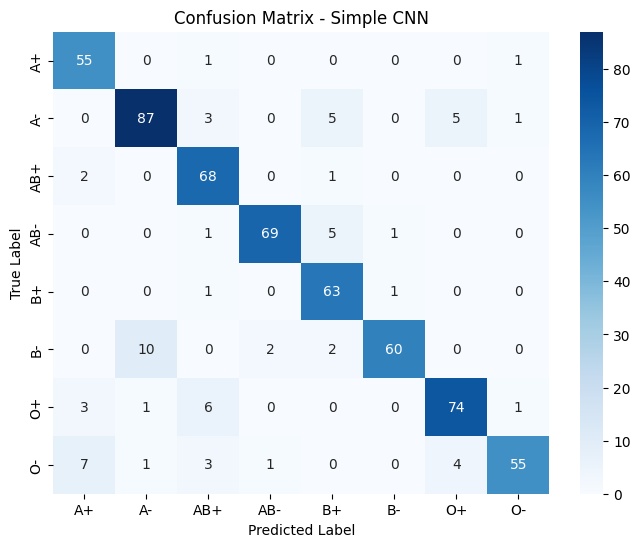


Classification Report - Simple CNN:
              precision    recall  f1-score   support

          A+       0.82      0.96      0.89        57
          A-       0.88      0.86      0.87       101
         AB+       0.82      0.96      0.88        71
         AB-       0.96      0.91      0.93        76
          B+       0.83      0.97      0.89        65
          B-       0.97      0.81      0.88        74
          O+       0.89      0.87      0.88        85
          O-       0.95      0.77      0.85        71

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.88       600

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step


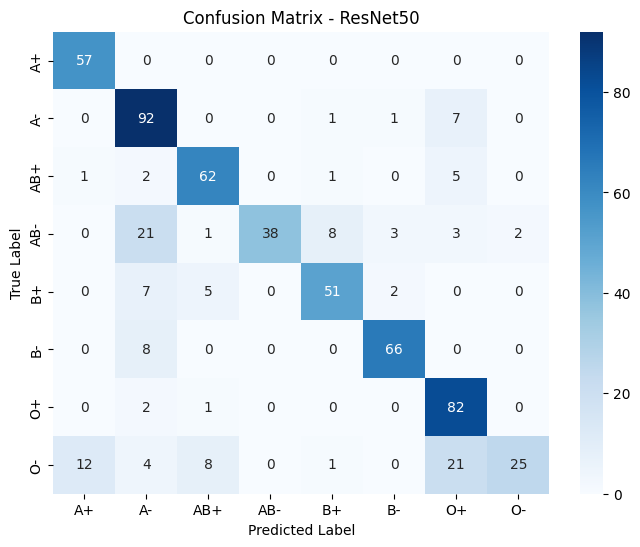


Classification Report - ResNet50:
              precision    recall  f1-score   support

          A+       0.81      1.00      0.90        57
          A-       0.68      0.91      0.78       101
         AB+       0.81      0.87      0.84        71
         AB-       1.00      0.50      0.67        76
          B+       0.82      0.78      0.80        65
          B-       0.92      0.89      0.90        74
          O+       0.69      0.96      0.81        85
          O-       0.93      0.35      0.51        71

    accuracy                           0.79       600
   macro avg       0.83      0.78      0.78       600
weighted avg       0.82      0.79      0.77       600

19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 380ms/step


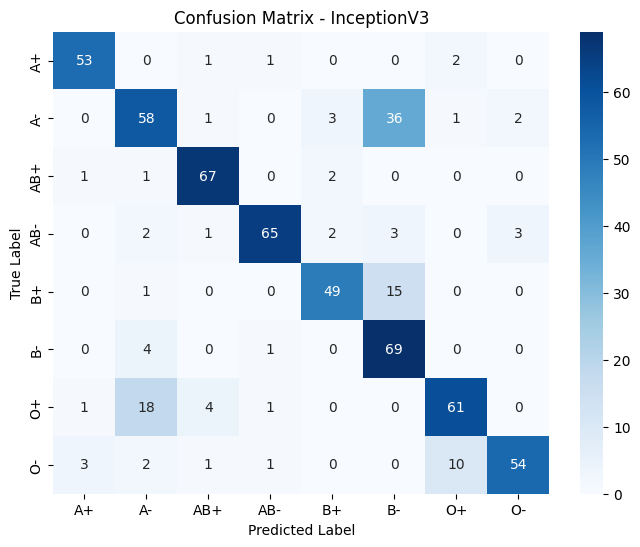


Classification Report - InceptionV3:
              precision    recall  f1-score   support

          A+       0.91      0.93      0.92        57
          A-       0.67      0.57      0.62       101
         AB+       0.89      0.94      0.92        71
         AB-       0.94      0.86      0.90        76
          B+       0.88      0.75      0.81        65
          B-       0.56      0.93      0.70        74
          O+       0.82      0.72      0.77        85
          O-       0.92      0.76      0.83        71

    accuracy                           0.79       600
   macro avg       0.82      0.81      0.81       600
weighted avg       0.81      0.79      0.80       600

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step


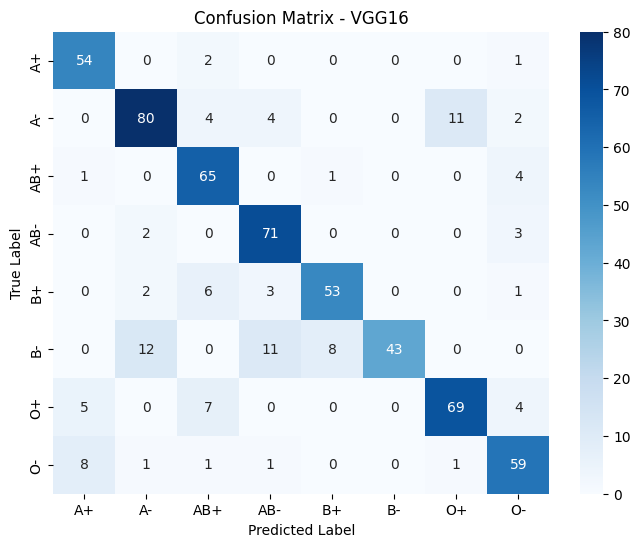


Classification Report - VGG16:
              precision    recall  f1-score   support

          A+       0.79      0.95      0.86        57
          A-       0.82      0.79      0.81       101
         AB+       0.76      0.92      0.83        71
         AB-       0.79      0.93      0.86        76
          B+       0.85      0.82      0.83        65
          B-       1.00      0.58      0.74        74
          O+       0.85      0.81      0.83        85
          O-       0.80      0.83      0.81        71

    accuracy                           0.82       600
   macro avg       0.83      0.83      0.82       600
weighted avg       0.84      0.82      0.82       600



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure X_test has the correct shape (batch_size, height, width, channels) for simple CNN
if X_test.ndim == 3:
    X_test_cnn = np.expand_dims(X_test, axis=-1)
else:
    X_test_cnn = X_test

# Get predictions for the test set for Simple CNN
y_pred_probs_cnn = simple_cnn_model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_probs_cnn, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get the class labels
class_names = label_encoder.classes_

# Generate and plot the confusion matrix for Simple CNN
cm_cnn = confusion_matrix(y_true, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Simple CNN')
plt.show()

# Print classification report for Simple CNN
print("\nClassification Report - Simple CNN:")
print(classification_report(y_true, y_pred_cnn, target_names=class_names))


# Get predictions for the test set for ResNet50 (requires 3 channels)
X_test_rgb = np.repeat(X_test[..., np.newaxis], 3, axis=-1)
y_pred_probs_resnet = resnet_model.predict(X_test_rgb)
y_pred_resnet = np.argmax(y_pred_probs_resnet, axis=1)

# Generate and plot the confusion matrix for ResNet50
cm_resnet = confusion_matrix(y_true, y_pred_resnet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - ResNet50')
plt.show()

# Print classification report for ResNet50
print("\nClassification Report - ResNet50:")
print(classification_report(y_true, y_pred_resnet, target_names=class_names))


# Get predictions for the test set for InceptionV3 (requires 3 channels)
y_pred_probs_inception = inception_model.predict(X_test_rgb)
y_pred_inception = np.argmax(y_pred_probs_inception, axis=1)

# Generate and plot the confusion matrix for InceptionV3
cm_inception = confusion_matrix(y_true, y_pred_inception)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_inception, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - InceptionV3')
plt.show()

# Print classification report for InceptionV3
print("\nClassification Report - InceptionV3:")
print(classification_report(y_true, y_pred_inception, target_names=class_names))


# Get predictions for the test set for VGG16 (requires 3 channels)
y_pred_probs_vgg = vgg_model.predict(X_test_rgb)
y_pred_vgg = np.argmax(y_pred_probs_vgg, axis=1)

# Generate and plot the confusion matrix for VGG16
cm_vgg = confusion_matrix(y_true, y_pred_vgg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - VGG16')
plt.show()

# Print classification report for VGG16
print("\nClassification Report - VGG16:")
print(classification_report(y_true, y_pred_vgg, target_names=class_names))

In [12]:
from google.colab import files
import cv2
import numpy as np
import tensorflow as tf

# Assuming 'simple_cnn_model', 'resnet_model', 'inception_model', 'vgg_model' are your trained models
models = {
    "Simple CNN": simple_cnn_model,
    "ResNet50": resnet_model,
    "InceptionV3": inception_model,
    "VGG16": vgg_model
}
# Assuming 'label_encoder' is your fitted LabelEncoder
# Assuming 'image_size' is the size used for training (e.g., (128, 128))

uploaded = files.upload()

for fn in uploaded.keys():
  # Load the image
  img_path = '/content/' + fn
  img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED) # Load image as is to check channels

  if img is not None:
    # Convert to grayscale if not already
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_processed_cnn = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_processed_rgb = img # Keep original for RGB models
    elif len(img.shape) == 3 and img.shape[2] == 4:
        img_processed_cnn = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
        img_processed_rgb = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB) # Convert to RGB for RGB models
    else: # Assume grayscale if not 3 or 4 channels
        img_processed_cnn = img
        img_processed_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) # Convert to RGB for RGB models


    # Preprocess the image for Simple CNN
    img_processed_cnn = cv2.resize(img_processed_cnn, image_size) # Resize image to the same size as training data
    img_processed_cnn = img_processed_cnn / 255.0  # Normalize pixel values to [0, 1]
    img_processed_cnn = np.expand_dims(img_processed_cnn, axis=-1) # Add channel dimension (for grayscale)
    img_processed_cnn = np.expand_dims(img_processed_cnn, axis=0)  # Add batch dimension

    # Preprocess the image for RGB models
    img_processed_rgb = cv2.resize(img_processed_rgb, image_size) # Resize image to the same size as training data
    img_processed_rgb = img_processed_rgb / 255.0  # Normalize pixel values to [0, 1]
    img_processed_rgb = np.expand_dims(img_processed_rgb, axis=0)  # Add batch dimension

    highest_confidence = -1
    most_probable_blood_group = "N/A"

    print(f"Predictions for image: {fn}")
    for model_name, model in models.items():
        if model_name == "Simple CNN":
            predictions = model.predict(img_processed_cnn)
        else: # ResNet50, InceptionV3, VGG16 expect RGB input
             predictions = model.predict(img_processed_rgb)

        predicted_class_index = np.argmax(predictions)
        predicted_blood_group = label_encoder.inverse_transform([predicted_class_index])[0]
        confidence = predictions[0][predicted_class_index] * 100 # Get confidence percentage

        print(f"  {model_name}: Predicted Blood Group = {predicted_blood_group}, Confidence = {confidence:.2f}%")

        if confidence > highest_confidence:
            highest_confidence = confidence
            most_probable_blood_group = predicted_blood_group

    print(f"\nMost probable blood group based on highest confidence across all models: {most_probable_blood_group} (Confidence: {highest_confidence:.2f}%)")

    # Predict using the best performing model (Simple CNN)
    #best_model = simple_cnn_model # Assuming Simple CNN was the best based on previous evaluation
    #predictions_best_model = best_model.predict(img_processed_cnn)
    #predicted_class_index_best_model = np.argmax(predictions_best_model)
    #predicted_blood_group_best_model = label_encoder.inverse_transform([predicted_class_index_best_model])[0]

    #print(f"Predicted blood group using the best performing model (Simple CNN): {predicted_blood_group_best_model}")

  else:
    print(f"Error loading image {fn}. Please make sure it's a valid image file.")

Saving cluster_7_2.BMP to cluster_7_2 (1).BMP
Predictions for image: cluster_7_2 (1).BMP
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
  Simple CNN: Predicted Blood Group = O-, Confidence = 94.26%
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
  ResNet50: Predicted Blood Group = A+, Confidence = 68.33%
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
  InceptionV3: Predicted Blood Group = O-, Confidence = 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
  VGG16: Predicted Blood Group = O-, Confidence = 53.73%

Most probable blood group based on highest confidence across all models: O- (Confidence: 100.00%)


In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def evaluate_models(models, X_test, y_test, label_encoder):
    """
    Evaluates multiple models on a test dataset and returns their performance metrics and confusion matrices.

    Args:
        models (dict): A dictionary where keys are model names and values are the trained Keras models.
        X_test (np.ndarray): The test image data.
        y_test (np.ndarray): The true test labels (one-hot encoded).
        label_encoder (LabelEncoder): The fitted LabelEncoder.

    Returns:
        tuple: A tuple containing two dictionaries:
               - performance_metrics (dict): Dictionary of accuracy and classification reports for each model.
               - confusion_matrices (dict): Dictionary of confusion matrices for each model.
    """
    performance_metrics = {}
    confusion_matrices = {}
    class_names = label_encoder.classes_
    y_true = np.argmax(y_test, axis=1)

    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")

        if model_name == "Simple CNN":
            # Ensure Simple CNN input has channel dimension if missing
            if X_test.ndim == 3:
                X_test_processed = np.expand_dims(X_test, axis=-1)
            else:
                X_test_processed = X_test
        else:
            # Convert grayscale to RGB by repeating the channel for other models
            X_test_processed = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

        # Get predictions
        y_pred_probs = model.predict(X_test_processed)
        y_pred = np.argmax(y_pred_probs, axis=1)

        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        confusion_matrices[model_name] = cm

        # Calculate classification report
        report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        performance_metrics[model_name] = report

        # Evaluate model to get loss and accuracy
        loss, accuracy = model.evaluate(X_test_processed, y_test, verbose=0)
        performance_metrics[model_name]['accuracy'] = accuracy

    return performance_metrics, confusion_matrices


Evaluating Simple CNN manually...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Evaluating ResNet50 manually...
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

Evaluating InceptionV3 manually...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Evaluating VGG16 manually...
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step

--- Simple CNN Performance (Manual Calculation) ---
Accuracy: 0.8850
Loss: 0.3113

Classification Report:
A+:
  precision: 0.8209
  recall: 0.9649
  f1-score: 0.8871
  support: 57.0000
A-:
  precision: 0.8788
  recall: 0.8614
  f1-score: 0.8700
  support: 101.0000
AB+:
  precision: 0.8193
  recall: 0.9577
  f1-score: 0.8831
  support: 71.0000
AB-:
  precision: 0.9583
  recall: 0.9079
  f1-score: 0.9324
  support: 76.0000
B+:
  precision: 0.8289
  recall: 0.9692
  f1-score: 0.8936
  support: 65.0000
B-:
  precision: 0.9677
  recall: 0.8108
  f1-score: 0.8824
  support: 74.0000
O+:
  precision: 0.8916
  recall: 0.8706
  f1-score: 0.8810
  support: 85.0000
O-:
  precision: 0.9483
  recall: 0.7746
  f

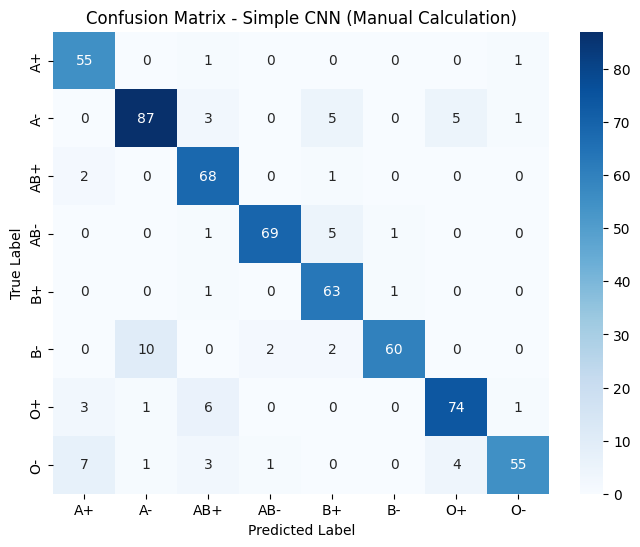


--- ResNet50 Performance (Manual Calculation) ---
Accuracy: 0.7883
Loss: 0.6867

Classification Report:
A+:
  precision: 0.8143
  recall: 1.0000
  f1-score: 0.8976
  support: 57.0000
A-:
  precision: 0.6765
  recall: 0.9109
  f1-score: 0.7764
  support: 101.0000
AB+:
  precision: 0.8052
  recall: 0.8732
  f1-score: 0.8378
  support: 71.0000
AB-:
  precision: 1.0000
  recall: 0.5000
  f1-score: 0.6667
  support: 76.0000
B+:
  precision: 0.8226
  recall: 0.7846
  f1-score: 0.8031
  support: 65.0000
B-:
  precision: 0.9167
  recall: 0.8919
  f1-score: 0.9041
  support: 74.0000
O+:
  precision: 0.6949
  recall: 0.9647
  f1-score: 0.8079
  support: 85.0000
O-:
  precision: 0.9259
  recall: 0.3521
  f1-score: 0.5102
  support: 71.0000
macro avg:
  precision: 0.8320
  recall: 0.7847
  f1-score: 0.7755
  support: 600.0000
weighted avg:
  precision: 0.8234
  recall: 0.7883
  f1-score: 0.7729
  support: 600.0000



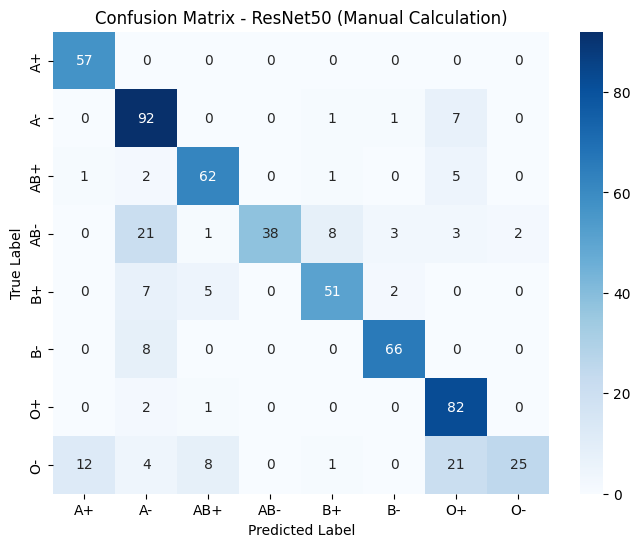


--- InceptionV3 Performance (Manual Calculation) ---
Accuracy: 0.7933
Loss: 1.4357

Classification Report:
A+:
  precision: 0.9138
  recall: 0.9298
  f1-score: 0.9217
  support: 57.0000
A-:
  precision: 0.6744
  recall: 0.5743
  f1-score: 0.6203
  support: 101.0000
AB+:
  precision: 0.8933
  recall: 0.9437
  f1-score: 0.9178
  support: 71.0000
AB-:
  precision: 0.9420
  recall: 0.8553
  f1-score: 0.8966
  support: 76.0000
B+:
  precision: 0.8750
  recall: 0.7538
  f1-score: 0.8099
  support: 65.0000
B-:
  precision: 0.5610
  recall: 0.9324
  f1-score: 0.7005
  support: 74.0000
O+:
  precision: 0.8243
  recall: 0.7176
  f1-score: 0.7673
  support: 85.0000
O-:
  precision: 0.9153
  recall: 0.7606
  f1-score: 0.8308
  support: 71.0000
macro avg:
  precision: 0.8249
  recall: 0.8084
  f1-score: 0.8081
  support: 600.0000
weighted avg:
  precision: 0.8144
  recall: 0.7933
  f1-score: 0.7953
  support: 600.0000



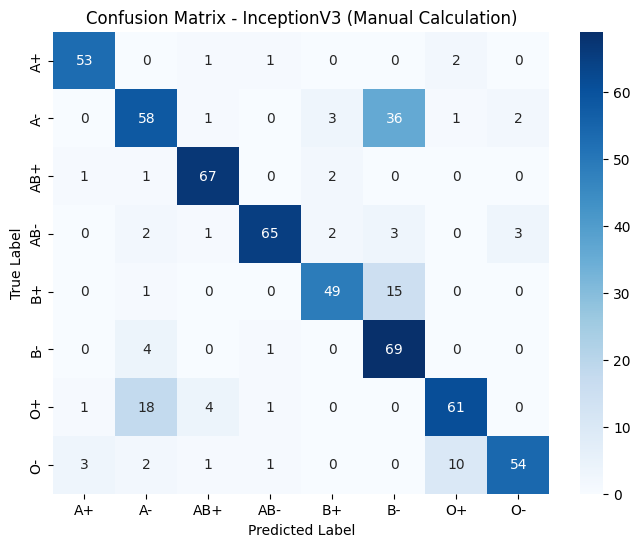


--- VGG16 Performance (Manual Calculation) ---
Accuracy: 0.8233
Loss: 0.4325

Classification Report:
A+:
  precision: 0.7941
  recall: 0.9474
  f1-score: 0.8640
  support: 57.0000
A-:
  precision: 0.8247
  recall: 0.7921
  f1-score: 0.8081
  support: 101.0000
AB+:
  precision: 0.7647
  recall: 0.9155
  f1-score: 0.8333
  support: 71.0000
AB-:
  precision: 0.7889
  recall: 0.9342
  f1-score: 0.8554
  support: 76.0000
B+:
  precision: 0.8548
  recall: 0.8154
  f1-score: 0.8346
  support: 65.0000
B-:
  precision: 1.0000
  recall: 0.5811
  f1-score: 0.7350
  support: 74.0000
O+:
  precision: 0.8519
  recall: 0.8118
  f1-score: 0.8313
  support: 85.0000
O-:
  precision: 0.7973
  recall: 0.8310
  f1-score: 0.8138
  support: 71.0000
macro avg:
  precision: 0.8346
  recall: 0.8285
  f1-score: 0.8220
  support: 600.0000
weighted avg:
  precision: 0.8357
  recall: 0.8233
  f1-score: 0.8202
  support: 600.0000



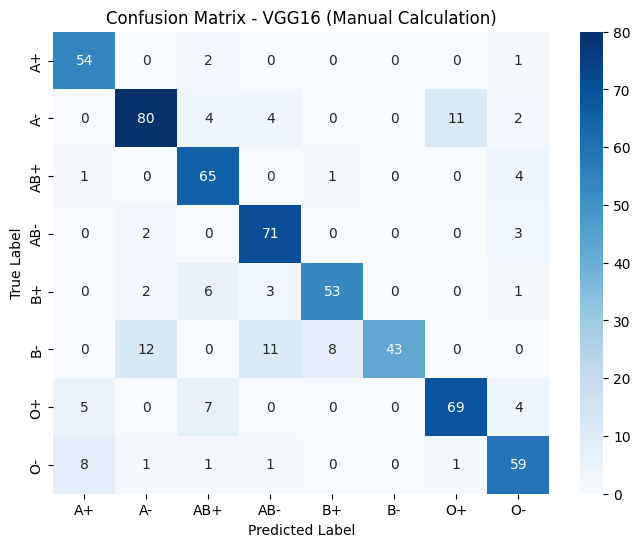

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

def evaluate_models_manual(models, X_test, y_test, label_encoder):
    """
    Evaluates multiple models on a test dataset and returns their performance metrics and confusion matrices.
    Calculates loss and accuracy manually.

    Args:
        models (dict): A dictionary where keys are model names and values are the trained Keras models.
        X_test (np.ndarray): The test image data.
        y_test (np.ndarray): The true test labels (one-hot encoded).
        label_encoder (LabelEncoder): The fitted LabelEncoder.

    Returns:
        tuple: A tuple containing two dictionaries:
               - performance_metrics (dict): Dictionary of accuracy and classification reports for each model.
               - confusion_matrices (dict): Dictionary of confusion matrices for each model.
    """
    performance_metrics = {}
    confusion_matrices = {}
    class_names = label_encoder.classes_
    y_true = np.argmax(y_test, axis=1)

    # Define a loss function for manual calculation (same as used for compiling)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    for model_name, model in models.items():
        print(f"\nEvaluating {model_name} manually...")

        if model_name == "Simple CNN":
            if X_test.ndim == 3:
                X_test_processed = np.expand_dims(X_test, axis=-1)
            elif X_test.ndim == 4 and X_test.shape[-1] == 1:
                 X_test_processed = X_test
            else:
                 X_test_processed = np.expand_dims(X_test, axis=-1)

        else:
            if X_test.ndim == 3:
                X_test_processed = np.repeat(X_test[..., np.newaxis], 3, axis=-1)
            elif X_test.ndim == 4 and X_test.shape[-1] == 3:
                 X_test_processed = X_test
            elif X_test.ndim == 4 and X_test.shape[-1] == 1:
                X_test_processed = np.repeat(X_test, 3, axis=-1)
            else:
                 X_test_processed = np.repeat(X_test[..., np.newaxis], 3, axis=-1)


        # Get predictions
        y_pred_probs = model.predict(X_test_processed)
        y_pred = np.argmax(y_pred_probs, axis=1)

        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        confusion_matrices[model_name] = cm

        # Calculate classification report
        report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        performance_metrics[model_name] = report

        # Manually calculate loss and accuracy
        # Calculate loss
        loss = loss_fn(y_test, y_pred_probs).numpy()

        # Calculate accuracy
        correct_predictions = np.equal(y_true, y_pred).sum()
        accuracy = correct_predictions / len(y_true)

        performance_metrics[model_name]['accuracy'] = accuracy
        performance_metrics[model_name]['loss'] = loss # Include loss in metrics for comparison

    return performance_metrics, confusion_matrices

# Evaluate all models manually
performance_metrics_manual, confusion_matrices_manual = evaluate_models_manual(models, X_test, y_test, label_encoder)

# Print performance metrics and plot confusion matrices
for model_name in models.keys():
    print(f"\n--- {model_name} Performance (Manual Calculation) ---")
    print(f"Accuracy: {performance_metrics_manual[model_name]['accuracy']:.4f}")
    print(f"Loss: {performance_metrics_manual[model_name]['loss']:.4f}")
    print("\nClassification Report:")
    report_str = ""
    for label, metrics in performance_metrics_manual[model_name].items():
        if label not in ['accuracy', 'loss']:
            if isinstance(metrics, dict):
                 report_str += f"{label}:\n"
                 for metric_name, value in metrics.items():
                     report_str += f"  {metric_name}: {value:.4f}\n"
            else:
                 report_str += f"{label}: {metrics:.4f}\n"
    print(report_str)


    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrices_manual[model_name], annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name} (Manual Calculation)')
    plt.show()

In [15]:
def select_best_model(performance_metrics):
    """
    Selects the best performing model based on accuracy.

    Args:
        performance_metrics (dict): Dictionary containing performance metrics for each model,
                                    including 'accuracy'.

    Returns:
        str: The name of the best performing model.
    """
    best_model_name = None
    highest_accuracy = -1

    for model_name, metrics in performance_metrics.items():
        if 'accuracy' in metrics:
            accuracy = metrics['accuracy']
            if accuracy > highest_accuracy:
                highest_accuracy = accuracy
                best_model_name = model_name
        else:
            print(f"Warning: Accuracy metric not found for model: {model_name}")

    return best_model_name

In [16]:
from google.colab import files
import cv2
import numpy as np
import tensorflow as tf

def predict_blood_group(image_path, model, model_name, label_encoder, image_size):
    """
    Loads and preprocesses an image, then uses a given model to predict the blood group
    and its confidence.

    Args:
        image_path (str): The path to the input image file.
        model (tf.keras.Model): The trained Keras model to use for prediction.
        model_name (str): The name of the model (used to determine expected input shape).
        label_encoder (LabelEncoder): The fitted LabelEncoder.
        image_size (tuple): The target size for resizing the image (width, height).

    Returns:
        tuple: A tuple containing the predicted blood group (str) and the confidence score (float).
               Returns (None, None) if the image cannot be loaded.
    """
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    if img is None:
        print(f"Error loading image {image_path}. Please make sure it's a valid image file.")
        return None, None

    # Convert to appropriate color space based on model
    if model_name == "Simple CNN":
        if len(img.shape) == 3 and img.shape[2] == 3:
            img_processed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        elif len(img.shape) == 3 and img.shape[2] == 4:
            img_processed = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
        else:
            img_processed = img # Assume grayscale if not 3 or 4 channels
    else: # ResNet50, InceptionV3, VGG16 expect RGB input
        if len(img.shape) == 3 and img.shape[2] == 3:
            img_processed = img # Already RGB
        elif len(img.shape) == 3 and img.shape[2] == 4:
            img_processed = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        else:
            img_processed = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) # Convert grayscale to RGB


    # Preprocess the image
    img_processed = cv2.resize(img_processed, image_size)
    img_processed = img_processed / 255.0  # Normalize pixel values to [0, 1]

    # Add channel dimension and batch dimension
    if model_name == "Simple CNN":
        img_processed = np.expand_dims(img_processed, axis=-1) # Add channel dimension for grayscale
    img_processed = np.expand_dims(img_processed, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img_processed)
    predicted_class_index = np.argmax(predictions)
    predicted_blood_group = label_encoder.inverse_transform([predicted_class_index])[0]
    confidence = predictions[0][predicted_class_index] * 100

    return predicted_blood_group, confidence


In [17]:
import json

print("Analyzing Performance Metrics for Nuanced Model Selection:")

for model_name, metrics in performance_metrics_manual.items():
    print(f"\n--- {model_name} Metrics ---")
    print(f"Overall Accuracy: {metrics.get('accuracy', 'N/A'):.4f}")
    print("Class-wise Metrics:")
    for label, class_metrics in metrics.items():
        if label not in ['accuracy', 'loss', 'macro avg', 'weighted avg']:
            if isinstance(class_metrics, dict):
                print(f"  {label}:")
                print(f"    Precision: {class_metrics.get('precision', 'N/A'):.4f}")
                print(f"    Recall: {class_metrics.get('recall', 'N/A'):.4f}")
                print(f"    F1-score: {class_metrics.get('f1-score', 'N/A'):.4f}")
                print(f"    Support: {class_metrics.get('support', 'N/A')}")

Analyzing Performance Metrics for Nuanced Model Selection:

--- Simple CNN Metrics ---
Overall Accuracy: 0.8850
Class-wise Metrics:
  A+:
    Precision: 0.8209
    Recall: 0.9649
    F1-score: 0.8871
    Support: 57.0
  A-:
    Precision: 0.8788
    Recall: 0.8614
    F1-score: 0.8700
    Support: 101.0
  AB+:
    Precision: 0.8193
    Recall: 0.9577
    F1-score: 0.8831
    Support: 71.0
  AB-:
    Precision: 0.9583
    Recall: 0.9079
    F1-score: 0.9324
    Support: 76.0
  B+:
    Precision: 0.8289
    Recall: 0.9692
    F1-score: 0.8936
    Support: 65.0
  B-:
    Precision: 0.9677
    Recall: 0.8108
    F1-score: 0.8824
    Support: 74.0
  O+:
    Precision: 0.8916
    Recall: 0.8706
    F1-score: 0.8810
    Support: 85.0
  O-:
    Precision: 0.9483
    Recall: 0.7746
    F1-score: 0.8527
    Support: 71.0

--- ResNet50 Metrics ---
Overall Accuracy: 0.7883
Class-wise Metrics:
  A+:
    Precision: 0.8143
    Recall: 1.0000
    F1-score: 0.8976
    Support: 57.0
  A-:
    Precision:

In [18]:
def select_best_model(performance_metrics):
    """
    Selects the best performing model based on a weighted combination of overall accuracy and
    macro-averaged F1-score, with a tie-breaker based on macro-averaged precision.

    Args:
        performance_metrics (dict): Dictionary containing performance metrics for each model,
                                    including 'accuracy', 'macro avg' (with 'f1-score' and 'precision').

    Returns:
        str: The name of the best performing model.
    """
    best_model_name = None
    best_score = -1
    # Weights for combining metrics (can be adjusted)
    accuracy_weight = 0.6
    f1_score_weight = 0.4

    for model_name, metrics in performance_metrics.items():
        accuracy = metrics.get('accuracy', 0)
        macro_avg_f1 = metrics.get('macro avg', {}).get('f1-score', 0)
        macro_avg_precision = metrics.get('macro avg', {}).get('precision', 0)

        # Calculate a combined score
        current_score = (accuracy * accuracy_weight) + (macro_avg_f1 * f1_score_weight)

        # Implement tie-breaking based on macro-averaged precision
        if current_score > best_score:
            best_score = current_score
            best_model_name = model_name
        elif current_score == best_score:
            # If scores are tied, compare macro-averaged precision
            best_macro_precision = performance_metrics.get(best_model_name, {}).get('macro avg', {}).get('precision', 0)
            if macro_avg_precision > best_macro_precision:
                best_model_name = model_name

    return best_model_name

# Test the refined select_best_model function
selected_model = select_best_model(performance_metrics_manual)
print(f"\nSelected best model based on refined criteria: {selected_model}")



Selected best model based on refined criteria: Simple CNN


In [19]:
# This cell implements the prediction functionality, allowing the user to upload an image,
# evaluate models, select the best one, and predict the blood group of the uploaded image.

while True:
    print("\nEvaluating models on the test set to select the best performing model...")
    # Evaluate all models on the test set to get updated performance metrics
    performance_metrics_manual, confusion_matrices_manual = evaluate_models_manual(models, X_test, y_test, label_encoder)

    # Select the best model based on the current evaluation metrics
    best_model_name = select_best_model(performance_metrics_manual)
    print(f"\nBest performing model selected for prediction: {best_model_name}")
    # Get the actual best model object from the models dictionary
    best_model = models[best_model_name]

    print("\nPlease upload a fingerprint image for blood group prediction.")
    # Prompt the user to upload a file
    uploaded = files.upload()

    # Process each uploaded file
    for fn in uploaded.keys():
        img_path = '/content/' + fn

        # Predict the blood group and confidence using the selected best model
        predicted_blood_group, confidence = predict_blood_group(
            img_path, best_model, best_model_name, label_encoder, image_size
        )

        # Check if image loading and prediction were successful
        if predicted_blood_group is not None:
            # Display the prediction results in the specified format
            print(f"blood group: {predicted_blood_group}")
            print(f"best model decided for the pic u entered: {best_model_name}")
            print(f"surety percentage: {confidence:.2f}%")

            # Optional Feedback Loop: Ask the user if the prediction is correct
            feedback = input("Is the prediction correct? (yes/no): ").lower()
            if feedback == 'yes':
                print("Great! Prediction confirmed.")
                break # Exit the inner loop (processing uploaded files)
            elif feedback == 'no':
                print("Prediction was incorrect. Re-evaluating models and attempting prediction again...")
                # The outer while loop will continue, triggering re-evaluation and re-selection.
                # In a more advanced scenario, you could implement logic to try the next best model here.
            else:
                print("Invalid input. Please enter 'yes' or 'no'.")
        else:
            # Error loading image was already printed inside predict_blood_group
            pass

    # If the prediction was correct and the user confirmed, break the outer while loop
    if predicted_blood_group is not None and feedback == 'yes':
        break



Evaluating models on the test set to select the best performing model...

Evaluating Simple CNN manually...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Evaluating ResNet50 manually...
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

Evaluating InceptionV3 manually...
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

Evaluating VGG16 manually...
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step

Best performing model selected for prediction: Simple CNN

Please upload a fingerprint image for blood group prediction.


Saving cluster_7_2.BMP to cluster_7_2 (2).BMP
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
blood group: O-
best model decided for the pic u entered: Simple CNN
surety percentage: 94.26%
Is the prediction correct? (yes/no): yes
Great! Prediction confirmed.


In [20]:
# Run this cell first to install dependencies
!pip install --upgrade optuna
!pip install optuna-integration[tfkeras]

# Then run the rest of the code

In [21]:
from optuna.integration import TFKerasPruningCallback

In [22]:
# Install the integration package first
!pip install optuna-integration[tfkeras]

# Then import
from optuna_integration.tfkeras import TFKerasPruningCallback

In [23]:
# ============================================================================
# PART 1: INSTALL OPTUNA AND INTEGRATION
# ============================================================================
!pip install optuna
!pip install optuna-integration[tfkeras]

import optuna
from optuna_integration.tfkeras import TFKerasPruningCallback  # ✅ FIXED IMPORT
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# ============================================================================
# PART 2: DEFINE OPTUNA OBJECTIVE FUNCTION FOR SIMPLE CNN
# ============================================================================

def create_optimized_simple_cnn(trial, input_shape, num_classes):
    """
    Creates a Simple CNN model with Optuna-tuned hyperparameters.
    """
    n_conv_layers = trial.suggest_int('n_conv_layers', 2, 4)
    dropout_rate = trial.suggest_float('dropout', 0.3, 0.7)
    dense_units = trial.suggest_int('dense_units', 64, 256, step=32)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    input_tensor = Input(shape=input_shape)
    x = input_tensor

    for i in range(n_conv_layers):
        filters = trial.suggest_int(f'filters_layer_{i}', 32, 128, step=32)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


def objective_simple_cnn(trial):
    """
    Optuna objective function for Simple CNN optimization.
    """
    model = create_optimized_simple_cnn(trial, input_shape_cnn, num_classes)

    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    pruning_callback = TFKerasPruningCallback(trial, 'val_accuracy')  # ✅ NOW WORKS

    history = model.fit(
        X_train, y_train,
        epochs=15,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, pruning_callback],
        verbose=0
    )

    val_accuracy = max(history.history['val_accuracy'])

    return val_accuracy


# ============================================================================
# PART 3: RUN OPTUNA OPTIMIZATION
# ============================================================================

print("Starting Optuna hyperparameter optimization for Simple CNN...")
study_simple_cnn = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3)
)

study_simple_cnn.optimize(objective_simple_cnn, n_trials=30, timeout=3600)

print("\n" + "="*80)
print("OPTUNA OPTIMIZATION RESULTS - SIMPLE CNN")
print("="*80)
print(f"Best Trial: {study_simple_cnn.best_trial.number}")
print(f"Best Validation Accuracy: {study_simple_cnn.best_value:.4f}")
print(f"\nBest Hyperparameters:")
for key, value in study_simple_cnn.best_params.items():
    print(f"  {key}: {value}")
print("="*80)


# ============================================================================
# PART 4: BUILD FINAL OPTIMIZED MODEL
# ============================================================================

print("\nTraining final Simple CNN with best hyperparameters...")

best_simple_cnn_model = create_optimized_simple_cnn(
    study_simple_cnn.best_trial,
    input_shape_cnn,
    num_classes
)

best_batch_size = study_simple_cnn.best_params['batch_size']

history_optimized_cnn = best_simple_cnn_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=best_batch_size,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

print("\nOptimized Simple CNN training complete!")


# ============================================================================
# ALTERNATIVE: VERSION WITHOUT PRUNING (IF INSTALLATION FAILS)
# ============================================================================

# If you still have issues, use this version WITHOUT pruning callback:

def objective_simple_cnn_no_pruning(trial):
    """
    Optuna objective WITHOUT pruning (simpler, no extra dependencies).
    """
    model = create_optimized_simple_cnn(trial, input_shape_cnn, num_classes)

    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # NO pruning callback - just train normally
    history = model.fit(
        X_train, y_train,
        epochs=10,  # Reduced epochs for faster trials
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )

    val_accuracy = max(history.history['val_accuracy'])

    return val_accuracy


# Run optimization without pruning
study_simple_cnn_no_pruning = optuna.create_study(direction='maximize')
study_simple_cnn_no_pruning.optimize(objective_simple_cnn_no_pruning, n_trials=3)

print(f"\nBest Accuracy (No Pruning): {study_simple_cnn_no_pruning.best_value:.4f}")
print(f"Best Parameters: {study_simple_cnn_no_pruning.best_params}")

[I 2026-02-17 11:50:21,852] A new study created in memory with name: no-name-85c08541-f96f-440a-8528-008861414da5


Starting Optuna hyperparameter optimization for Simple CNN...


[I 2026-02-17 11:51:10,981] Trial 0 finished with value: 0.8616666793823242 and parameters: {'n_conv_layers': 3, 'dropout': 0.3147236648582744, 'dense_units': 256, 'learning_rate': 1.5018210229793415e-05, 'filters_layer_0': 32, 'filters_layer_1': 32, 'filters_layer_2': 64, 'batch_size': 32}. Best is trial 0 with value: 0.8616666793823242.
[I 2026-02-17 11:52:20,191] Trial 1 finished with value: 0.8583333492279053 and parameters: {'n_conv_layers': 2, 'dropout': 0.5197394604593646, 'dense_units': 192, 'learning_rate': 3.8321833296721096e-05, 'filters_layer_0': 128, 'filters_layer_1': 64, 'batch_size': 16}. Best is trial 0 with value: 0.8616666793823242.
[I 2026-02-17 11:53:08,203] Trial 2 finished with value: 0.7133333086967468 and parameters: {'n_conv_layers': 3, 'dropout': 0.560748642992287, 'dense_units': 192, 'learning_rate': 0.0011684698387944882, 'filters_layer_0': 64, 'filters_layer_1': 64, 'filters_layer_2': 32, 'batch_size': 64}. Best is trial 0 with value: 0.8616666793823242.
[


OPTUNA OPTIMIZATION RESULTS - SIMPLE CNN
Best Trial: 27
Best Validation Accuracy: 0.9117

Best Hyperparameters:
  n_conv_layers: 4
  dropout: 0.6052408075306284
  dense_units: 224
  learning_rate: 0.00010274584081521511
  filters_layer_0: 96
  filters_layer_1: 96
  filters_layer_2: 64
  filters_layer_3: 32
  batch_size: 16

Training final Simple CNN with best hyperparameters...
Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.3824 - loss: 2.0806 - val_accuracy: 0.1750 - val_loss: 3.5683
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7379 - loss: 0.6970 - val_accuracy: 0.7600 - val_loss: 0.6169
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7956 - loss: 0.5272 - val_accuracy: 0.8517 - val_loss: 0.3472
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8394 - loss: 0.4141 - val_accuracy: 0.8450 - val_loss: 0.3337
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8604 - loss: 0.3722 - val_accuracy

[I 2026-02-17 12:18:31,918] A new study created in memory with name: no-name-121f2251-fb95-4a38-8d6c-7ddfb3415cea



Optimized Simple CNN training complete!


[I 2026-02-17 12:19:54,409] Trial 0 finished with value: 0.46166667342185974 and parameters: {'n_conv_layers': 2, 'dropout': 0.41658668911446156, 'dense_units': 256, 'learning_rate': 0.0007031880828762347, 'filters_layer_0': 96, 'filters_layer_1': 96, 'batch_size': 16}. Best is trial 0 with value: 0.46166667342185974.
[I 2026-02-17 12:20:49,767] Trial 1 finished with value: 0.8733333349227905 and parameters: {'n_conv_layers': 4, 'dropout': 0.5488466061951394, 'dense_units': 160, 'learning_rate': 3.542331943724321e-05, 'filters_layer_0': 64, 'filters_layer_1': 64, 'filters_layer_2': 32, 'filters_layer_3': 64, 'batch_size': 32}. Best is trial 1 with value: 0.8733333349227905.
[I 2026-02-17 12:21:39,865] Trial 2 finished with value: 0.16333332657814026 and parameters: {'n_conv_layers': 2, 'dropout': 0.5083214442758999, 'dense_units': 256, 'learning_rate': 0.0004275577978804024, 'filters_layer_0': 128, 'filters_layer_1': 96, 'batch_size': 64}. Best is trial 1 with value: 0.8733333349227905


Best Accuracy (No Pruning): 0.8733
Best Parameters: {'n_conv_layers': 4, 'dropout': 0.5488466061951394, 'dense_units': 160, 'learning_rate': 3.542331943724321e-05, 'filters_layer_0': 64, 'filters_layer_1': 64, 'filters_layer_2': 32, 'filters_layer_3': 64, 'batch_size': 32}
